# Fresh Water Lens

In this Exercise, we will construct the Fresh Water Lens problem in Flopy. The model has been checked in PMWIN.

Creating the MODFLOW model:

In [1]:
import flopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
L = 10000 #problem lenght [m]
D = 150 #problem depth [m]
delx = 100 #block size x direction
delz = 10 #block size z direction
dely = 1 #block size y direction

nrow = 1

ncol = int(L/delx) # number of columns

nlay = int(D/delz) # number of layers

stress_periods = 11 # Model stress periods [number]

Initial_C = 19000 # Initial concentration of the salt-water

bouyancy = 0.025 # adopted buoyancy

K = 25 #m/d hydraulic conductivity

vka = 10 # vertical hydraulica conductivity

ne = 0.35 # effective porosity

alpha_L = 0 # longitudinal dispersivity
alpha_T = 0 # transversal dispersivity

recharge = 365/365 # recharge mm/d

Recharge_C = 0 # Concentration of the recharge face

In [3]:
# Create the basic MODFLOW model structure
modelname = 'lens'
workspace = '..'
swt = flopy.seawat.Seawat(modelname, exe_name=os.path.join('..','swt_v4x64'), model_ws='.') #initializing the model

#Model Top:
henry_top = 0

#Model bottoms:
henry_botm = np.linspace(henry_top - delz, -150, 15)


# Definiing the stress period intervals:
repeat = list(np.repeat(9131.25, 10))
stp_repeat = list(np.repeat(25,10))

# Add DIS package to the MODFLOW model
dis = flopy.modflow.ModflowDis(swt, nlay = 15, nrow = 1, ncol = 100, nper=11, delr=100,
                               delc=1, laycbd=0, top=henry_top,
                               botm=henry_botm, perlen=[1e-9]+repeat, nstp=[1]+stp_repeat)


# Variables for the BAS package

#Defining the ibound matrix:
ibound = np.ones((15, 1, int(ncol)), dtype=np.int32)
ibound[0, 0, 0:30] = np.repeat(-1,30)
ibound[0, 0, 70:100] = np.repeat(-1,30)
print(ibound[0,0,:])

#Creating the BAS package, starting heads = 0 in the whole model
bas = flopy.modflow.ModflowBas(swt, ibound, 0)

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1]


In [4]:
#LPF package:
ipakcb = 53 # This makes sure the flow budget is saved

# Creating the LPF package for the flow model
lpf = flopy.modflow.ModflowLpf(swt, hk=K, vka=K/10, laytyp=0, ipakcb = ipakcb)

In [5]:
pcg = flopy.modflow.ModflowPcg(swt) #Addind the PCG solver

In [6]:
oc = flopy.modflow.ModflowOc( #Creating the output package for the flow model
    swt,
    stress_period_data={(0, 0): ["save head", "save budget"]},
    compact=True,
)

In [7]:
# Creating the recharge package, with 1mm/d recharge at the island
rech = np.concatenate([np.repeat(0,30),np.repeat(0.001, 40), np.repeat(0, 30)])
rech = rech[np.newaxis,:]
rch = flopy.modflow.ModflowRch(swt, rech=rech)

In [8]:
#Create MT3DMS model structure
timprs = np.linspace(0,91312.5,10)
timprs[0] = 0.01

#This defines the BTN package:

btn = flopy.mt3d.Mt3dBtn(
    swt,
    nprs=11,
    timprs = timprs,
    prsity=ne,
    #icbund = ibound,
    sconc=19000,
    ifmtcn=0,
    ncomp=1
)

#The advetion package with finite difference solution (mixelm = 0):

adv = flopy.mt3d.Mt3dAdv(swt, mixelm=0)

# THe DSP package with 0 dispersion coef. and 0 long. dispers.
dsp = flopy.mt3d.Mt3dDsp(swt, al=0.0, trpt=1.0, trpv=1.0, dmcoef=0)

# Adding the GCG solver for the MT3DMS model
gcg = flopy.mt3d.Mt3dGcg(swt, iter1=500, mxiter=1, isolve=1, cclose=1e-7)


#Defining the Sink and Source terms:
from flopy import mt3d
itype = mt3d.Mt3dSsm.itype_dict()
#print(itype)
ssm_data = {}
dat = []
for i in range(0,30):
    dat.append((0,0,i,19000,itype['BAS6'])) # Adding the contant source from the sea
for i in range(70,100):
    dat.append((0,0,i,19000,itype['BAS6'])) # Adding the contant source from the sea
#print(flopy.mt3d.Mt3dSsm.get_default_dtype(ncomp = 1))
ssm_data[0] = dat


# Adding the SSM package to the model, with 0 concentration in the recharge.
ssm = flopy.mt3d.Mt3dSsm(swt, crch = 0, stress_period_data = ssm_data)#, stress_period_data = ssm_data)

ssm.dtype

dtype([('k', '<i4'), ('i', '<i4'), ('j', '<i4'), ('css', '<f4'), ('itype', '<i4')])

In [9]:
# Creating the SEAWAT Variable Density Flow (VDF) package. Parameters were copied from the PMWIN file.
vdf = flopy.seawat.SeawatVdf(
    swt,
    mt3drhoflg = -1,
    mfnadvfd = 1,
    nswtcpl = 0,
    denseref = 1000,
    drhodprhd = 0,
    prhdref =0,
    nsrhoeos = 1,
    mtrhospec = 1,
    drhodc = 0.001316,
    crhoref = 0,
    iwtable=0,
    dt0 = 0.01
)

In [10]:
swt.write_input()

Util2d rech_1: locat is None, but model does not support free format and how is internal...resetting how = external


## Running the Model:

In [11]:
success, buff = swt.run_model(silent=True, report=True)
if not success:
    raise Exception("SEAWAT did not terminate normally.")

In [12]:

import flopy.utils.binaryfile as bf
ucnobj = bf.UcnFile("MT3D001.UCN", model=swt)
times = ucnobj.get_times()
concentration = ucnobj.get_data(totim=times[-1])

## Reading the Output:

In [13]:
cbbobj = bf.CellBudgetFile("lens.cbc")
times = cbbobj.get_times()
qx = cbbobj.get_data(text="flow right face", totim=times[-1])[0]
qy = np.zeros((nlay, nrow, int(ncol)), dtype=np.float32)
qz = cbbobj.get_data(text="flow lower face", totim=times[-1])[0]

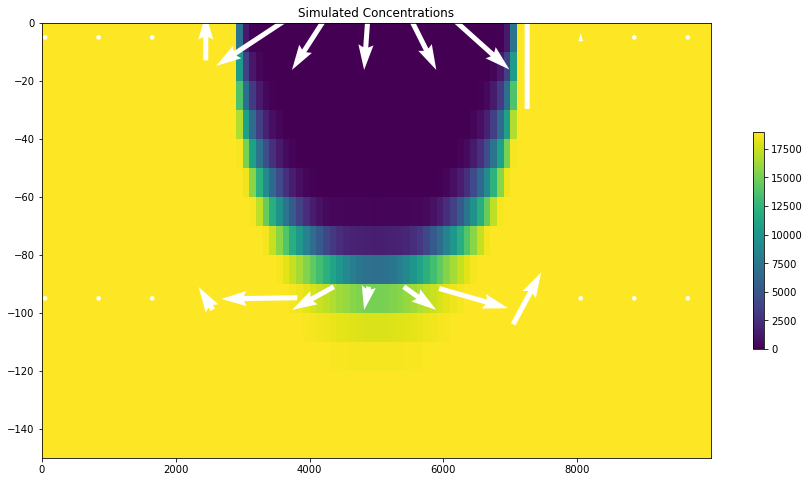

In [14]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1, 1, 1)
pmv = flopy.plot.PlotCrossSection(model=swt, ax=ax, line={"row": 0})
arr = pmv.plot_array(concentration)
pmv.plot_vector(qx, qy, -qz, color="white", kstep=9, hstep=8)
plt.colorbar(arr, shrink=0.5, ax=ax)
ax.set_title("Simulated Concentrations");

## Comparing the TimeSeries Simulation in the Three Locations:

Text(0, 0.5, 'Concentration [mg/L]')

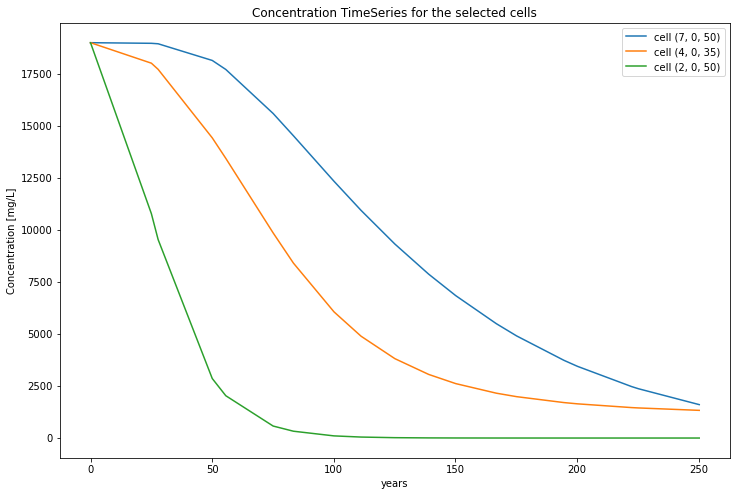

In [15]:
points = [(7,0,50),(4,0,35),(2,0,50)]


keys = []
tss = []
for point in points:
    ts = ucnobj.get_ts(point)
    name = "cell "+str(point)
    keys.append(name)
    tss.append(ts[:,1])
dic = dict(zip(keys,tss))
import pandas as pd

df = pd.DataFrame(dic)

df.index = ts[:,0]/365

fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(1, 1, 1)
df.plot.line(ax = ax)
ax.set_xlabel("years")
ax.set_title("Concentration TimeSeries for the selected cells")
ax.set_ylabel("Concentration [mg/L]")

* The fresh lens formed with the island takes 30 years to reach around 30 m depth, and over 150 years to reach 50 m depth.
* The Fresh water lens has reached its final form in approximately 250 years.


## Analytical versus numerical Solution:

Text(0.5, 1.0, 'Simulated Concentrations (Clipped to match Anal. solution)')

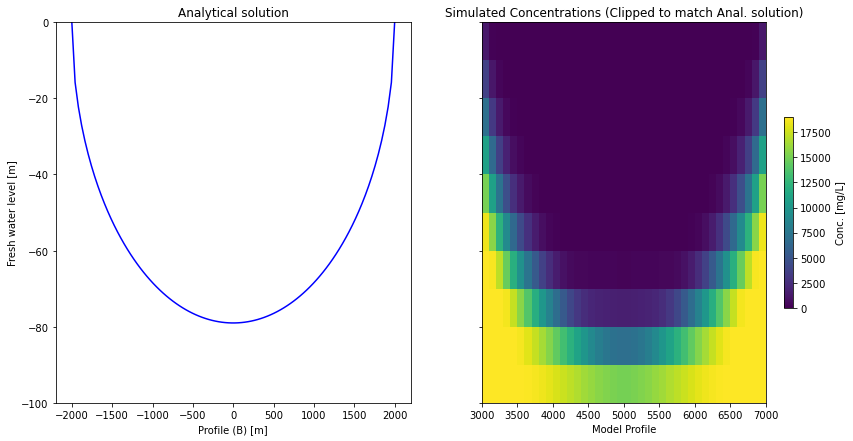

In [16]:
x = np.linspace(-2000,2000,100)
alpha = 0.025
H = np.sqrt(0.001*(0.25*4000**2-x**2)/(K*(1+0.025)*0.025))
H = - H
fig, ax = plt.subplots(1, 2, sharey = True, figsize = (14,7))
ax[0].plot(x, H, "b-")
ax[0].set_ylabel("Fresh water level [m]")
ax[0].set_xlabel("Profile (B) [m]")
ax[0].set_title("Analytical solution")
pmv = flopy.plot.PlotCrossSection(model=swt, ax=ax[1], line={"row": 0}, extent = (3000,7000,-100, 0))
arr = pmv.plot_array(concentration)
plt.colorbar(arr, shrink=0.5, ax=ax[1], label = "Conc. [mg/L]")
ax[1].set_xlabel("Model Profile")
ax[1].set_title("Simulated Concentrations (Clipped to match Anal. solution)")

* The above graph show us how the analytical solution is compared to the numerical solution. Although they are not exactly the same, one can argue that they are similar enough. Indeed, the analytical solution seem to be a good approximation to the reality.
* An important point to note, however, is that the solution analytically is steady-state, and in the model, the steady-state solution is only obtained in over 250 years. This implies that, although analytical solution are important, they can give a misleading idea on the fresh water storage because they ignore posssible history of the system.
* Different tide levels and changes from the past might be important in the today characterization of the groundwater salinity and the presence of fresh lenses. In the above example, 250 years were necessary in a permeable aquifer. In an less permeable one, this can be longer.

## Adding dispersion to the model:

In [17]:
# THe DSP package with 0 dispersion coef. and 1 long. dispers, 0.1 trans. dispers.
dsp = flopy.mt3d.Mt3dDsp(swt, al=1.0, trpt=0.1, trpv=0.1, dmcoef=0)

In [18]:
swt.write_input()

Util2d rech_1: locat is None, but model does not support free format and how is internal...resetting how = external


In [19]:
uccess, buff = swt.run_model(silent=True, report=True)
if not success:
    raise Exception("SEAWAT did not terminate normally.")

In [20]:
import flopy.utils.binaryfile as bf
ucnobj = bf.UcnFile("MT3D001.UCN", model=swt)
times = ucnobj.get_times()
concentration = ucnobj.get_data(totim=times[-1])

In [21]:
cbbobj = bf.CellBudgetFile("lens.cbc")
times = cbbobj.get_times()
qx = cbbobj.get_data(text="flow right face", totim=times[-1])[0]
qy = np.zeros((nlay, nrow, int(ncol)), dtype=np.float32)
qz = cbbobj.get_data(text="flow lower face", totim=times[-1])[0]

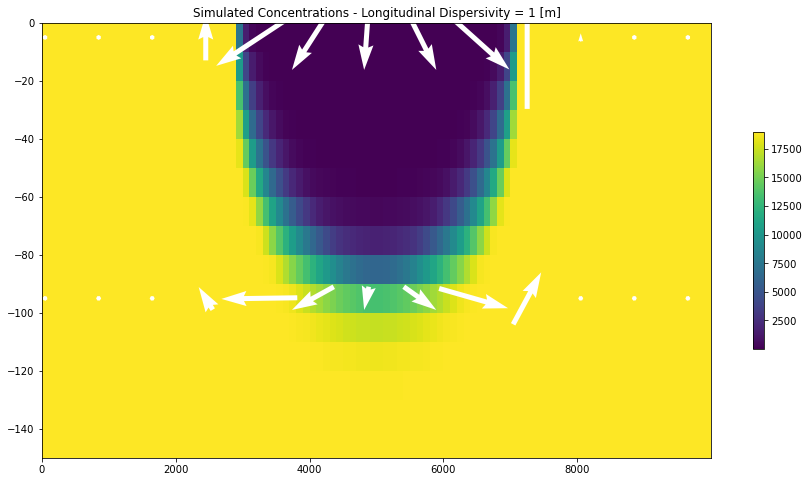

In [22]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1, 1, 1)
pmv = flopy.plot.PlotCrossSection(model=swt, ax=ax, line={"row": 0})
arr = pmv.plot_array(concentration)
pmv.plot_vector(qx, qy, -qz, color="white", kstep=9, hstep=8)
plt.colorbar(arr, shrink=0.5, ax=ax)
ax.set_title("Simulated Concentrations - Longitudinal Dispersivity = 1 [m]");

* The new model achieved the same final solution. The Fresh water lens has slightly less depth and size as the previous model.

* This happens because the dispersion causes more salt to mix with the fresh water, resulting in a larger brine layer with intermediate concentrations between the fresh and the salt water.

* Overal the added difussion term results in even longer times to reach the steady-state solution for the fresh-saltwater interface

Text(0, 0.5, 'Concentration [mg/L]')

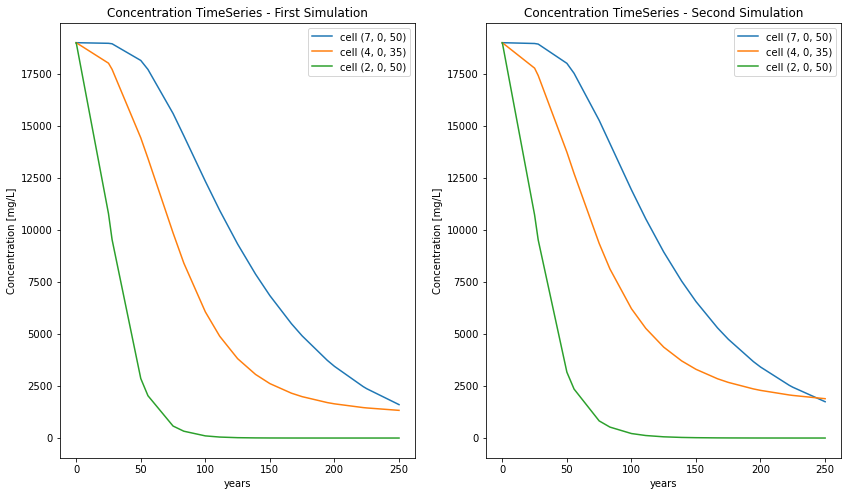

In [23]:
points = [(7,0,50),(4,0,35),(2,0,50)]


keys = []
tss = []
for point in points:
    ts = ucnobj.get_ts(point)
    name = "cell "+str(point)
    keys.append(name)
    tss.append(ts[:,1])
dic = dict(zip(keys,tss))
import pandas as pd

df2 = pd.DataFrame(dic)

df2.index = ts[:,0]/365

fig, ax = plt.subplots(1,2, figsize = (14,8))
df.plot.line(ax = ax[0])
ax[0].set_xlabel("years")
ax[0].set_title("Concentration TimeSeries - First Simulation")
ax[0].set_ylabel("Concentration [mg/L]")

df2.plot.line(ax = ax[1])
ax[1].set_xlabel("years")
ax[1].set_title("Concentration TimeSeries - Second Simulation")
ax[1].set_ylabel("Concentration [mg/L]")

The concentration time series graph shows that there is a delay in the reduction of the concentrations in the cells (5,1,36) and (8,1,51). The final value for concentration in the deeper layers of the model is higher than the obtained in the first simulation.
Visually, we do not note much changes in the shallower cell (3,1,51)

## Abstraction of wells:

Considering the population of around 100.000 people, with a consumpion of 150 L per person per day, we have a demand of $1.5E4$ m3/day. Assuming an Island of 10 km (our model has 1 m). The demand for the cross section would then be: $1.5E4/1E4 = 1.5$ m3/d

The model built will have the following characteristics:

- Conditions from day 0 to year 250 will be the initial conditions from the current model (fwlens003).
- Future conditions will be simulated beyond year 250, with three wells placed pumping 0.5 m3/d each totalling 1.5 m3/d/m'.
- Boundary conditions and aquifer properties will remain the same for both present and future, except that in the future, wells are added.

### Updating the DIS package:

In [24]:
# Definiing the stress period intervals:
repeat = list(np.repeat(9131.25, 20))
stp_repeat = list(np.repeat(25,20))

# Add DIS package to the MODFLOW model
dis = flopy.modflow.ModflowDis(swt, nlay = 15, nrow = 1, ncol = 100, nper=21, delr=100,
                               delc=1, laycbd=0, top=henry_top,
                               botm=henry_botm, perlen=[1e-9]+repeat, nstp=[1]+stp_repeat)


In [25]:
stress_period_data = {}
well_data_not_pumping = [(4,0,40,0), (4,0,50,0), (4,0,60,0)]
well_data_pumping = [(4,0,40,-0.5), (4,0,50,-0.5), (4,0,60,-0.5)] # Wells placed at 50 m depth, with horizontal spacing of 1000 meters
# and pumping rate of 0.5 m3/d
for i in range(11):
    stress_period_data[i] = well_data_not_pumping
for i in range(11,21):
    stress_period_data[i] = well_data_pumping

wel = flopy.modflow.ModflowWel(swt, stress_period_data = stress_period_data)


In [26]:
## Redefining the mt3dms outputs:

#Create MT3DMS model structure
timprs = np.linspace(0,91312.5*2,20)
timprs[0] = 0.01

#This defines the BTN package:

btn = flopy.mt3d.Mt3dBtn(
    swt,
    nprs=11,
    timprs = timprs,
    prsity=ne,
    #icbund = ibound,
    sconc=19000,
    ifmtcn=0,
    ncomp=1
)

In [27]:
swt.write_input()

Util2d rech_1: locat is None, but model does not support free format and how is internal...resetting how = external


In [28]:
success, buff = swt.run_model(silent=True, report=True)
if not success:
    raise Exception("SEAWAT did not terminate normally.")

In [29]:
import flopy.utils.binaryfile as bf
ucnobj = bf.UcnFile("MT3D001.UCN", model=swt)
times = ucnobj.get_times()
concentration = ucnobj.get_data(totim=times[-1])

In [30]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1, 1, 1)
pmv = flopy.plot.PlotCrossSection(model=swt, ax=ax, line={"row": 0})
conc= ucnobj.get_data(totim=times[-1])
arr = pmv.plot_array(conc)
#arr = pmv.plot_array(concentration)
plt.colorbar(arr, shrink=0.5, ax=ax)
ax.set_title("Simulated Concentrations")

from celluloid import Camera
camera = Camera(fig)


# funciton takes frame as an input
for frame in range(1,len(times)): 
    
    conc= ucnobj.get_data(totim=times[frame])
    #pmv = flopy.plot.PlotCrossSection(model=swt, ax=ax, line={"row": 0})
    arr = pmv.plot_array(conc)
    #plt.colorbar(arr, shrink=0.5, ax=ax)
    #ax.set_title("Simulated Concentrations - "+ str(times[frame]/365) + "years")
    camera.snap()
    
    

animation = camera.animate(interval = 1000)

animation.save('simulated_concentrations.gif', writer = 'Pillow')

plt.close()

MovieWriter Pillow unavailable; using Pillow instead.


![GIF image](simulated_concentrations.gif)

The above animation show in the first half the formation of the fresh water lens, as in the previous simulation. On the second half, pumping is turned on, and the lens reduces to about 2/3 of the original size. However the salinity increases significantly in the region around the wells location (around 50 m depth).

## Checking the concentrations at the well sites:

Text(0, 0.5, 'Concentration [mg/L]')

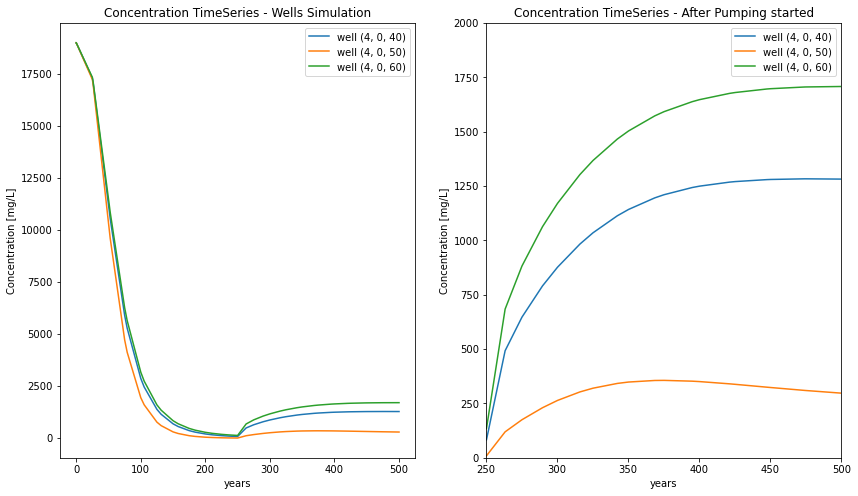

In [31]:
points = [(4,0,40),(4,0,50),(4,0,60)]


keys = []
tss = []
for point in points:
    ts = ucnobj.get_ts(point)
    name = "well "+str(point)
    keys.append(name)
    tss.append(ts[:,1])
dic = dict(zip(keys,tss))
import pandas as pd

df3 = pd.DataFrame(dic)

df3.index = ts[:,0]/365

fig, ax = plt.subplots(1,2, figsize = (14,8), sharey = False)
df3.plot.line(ax = ax[0])
ax[0].set_xlabel("years")
ax[0].set_title("Concentration TimeSeries - Wells Simulation")
ax[0].set_ylabel("Concentration [mg/L]")
df3.plot.line(ax = ax[1])
ax[1].set_xlim(250,500)
ax[1].set_ylim(0,2000)
ax[1].set_xlabel("years")
ax[1].set_title("Concentration TimeSeries - After Pumping started")
ax[1].set_ylabel("Concentration [mg/L]")


* The figure above, on the left show the whole concentration evolution in the well, and on the right, shows the concentration evolution after the well placement.

* Although concentrations in all wells have risen too much above the limit, the concentration in the well in the middle of the profile (4,0,50), is much lower than in the wells more far way from the center (4,0,40) and (4,0,60).

* Considering a recharge rate of 1 mm/day and the 4000 x 1 area, the total recharge is: 4 m3/d/m. We can see that even with a sustainable extraction, from a water quantity point of view, we can have overal unsustainability due to salinity rise.

### Checking the results with half of the original pumping rates:

In [32]:
stress_period_data = {}
well_data_not_pumping = [(4,0,40,0), (4,0,50,0), (4,0,60,0)]
well_data_pumping = [(4,0,40,-0.25), (4,0,50,-0.25), (4,0,60,-0.25)] # Wells placed at 50 m depth, with horizontal spacing of 1000 meters
# and pumping rate of 0.5 m3/d
for i in range(11):
    stress_period_data[i] = well_data_not_pumping
for i in range(11,21):
    stress_period_data[i] = well_data_pumping

wel = flopy.modflow.ModflowWel(swt, stress_period_data = stress_period_data)

swt.write_input()

success, buff = swt.run_model(silent=True, report=True)
if not success:
    raise Exception("SEAWAT did not terminate normally.")
    
ucnobj = bf.UcnFile("MT3D001.UCN", model=swt)
times = ucnobj.get_times()


Util2d rech_1: locat is None, but model does not support free format and how is internal...resetting how = external


Text(0, 0.5, 'Concentration [mg/L]')

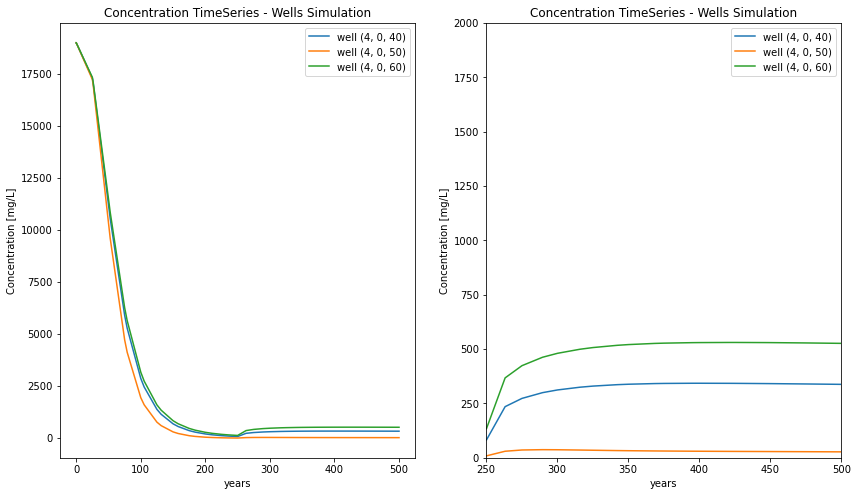

In [33]:
points = [(4,0,40),(4,0,50),(4,0,60)]


keys = []
tss = []
for point in points:
    ts = ucnobj.get_ts(point)
    name = "well "+str(point)
    keys.append(name)
    tss.append(ts[:,1])
dic = dict(zip(keys,tss))
import pandas as pd

df3 = pd.DataFrame(dic)

df3.index = ts[:,0]/365

fig, ax = plt.subplots(1,2, figsize = (14,8), sharey = False)
df3.plot.line(ax = ax[0])
ax[0].set_xlabel("years")
ax[0].set_title("Concentration TimeSeries - Wells Simulation")
ax[0].set_ylabel("Concentration [mg/L]")
df3.plot.line(ax = ax[1])
ax[1].set_xlim(250,500)
ax[1].set_ylim(0,2000)
ax[1].set_xlabel("years")
ax[1].set_title("Concentration TimeSeries - Wells Simulation")
ax[1].set_ylabel("Concentration [mg/L]")


* With the new pumping rates, we can get at least two wells with acceptable drinking water salinity values.
* The well in the middle of the lens (well (4,0,50)) has not been affected by the salt upconing

### Simulation with closer wells

* Since wells are being affected by being closer to the border, we will shorten their distance and put them all closer to each other in the middle of the island.

In [35]:
stress_period_data = {}
well_data_not_pumping = [(4,0,45,0), (4,0,50,0), (4,0,55,0)]
well_data_pumping = [(4,0,45,-0.25), (4,0,50,-0.25), (4,0,55,-0.25)] # Wells placed at 50 m depth, with horizontal spacing of 1000 meters
# and pumping rate of 0.5 m3/d
for i in range(11):
    stress_period_data[i] = well_data_not_pumping
for i in range(11,21):
    stress_period_data[i] = well_data_pumping

wel = flopy.modflow.ModflowWel(swt, stress_period_data = stress_period_data)

swt.write_input()

success, buff = swt.run_model(silent=True, report=True)
if not success:
    raise Exception("SEAWAT did not terminate normally.")
    
ucnobj = bf.UcnFile("MT3D001.UCN", model=swt)
times = ucnobj.get_times()

Util2d rech_1: locat is None, but model does not support free format and how is internal...resetting how = external


Text(0, 0.5, 'Concentration [mg/L]')

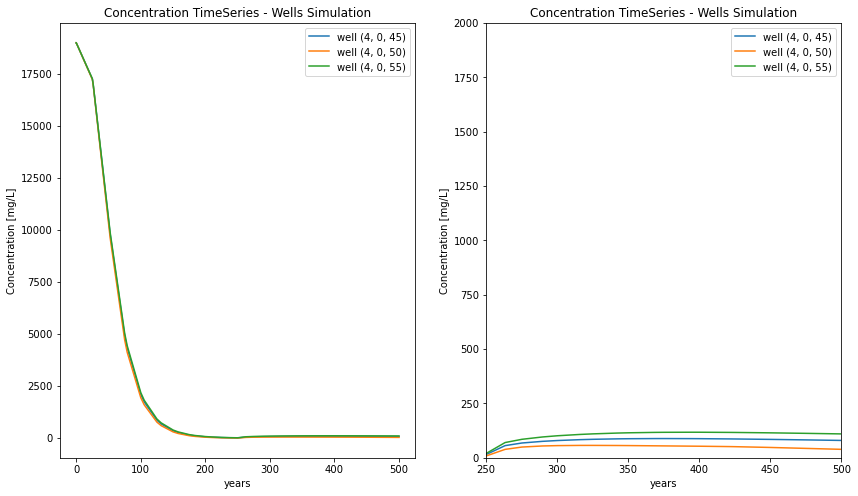

In [36]:
points = [(4,0,45),(4,0,50),(4,0,55)]


keys = []
tss = []
for point in points:
    ts = ucnobj.get_ts(point)
    name = "well "+str(point)
    keys.append(name)
    tss.append(ts[:,1])
dic = dict(zip(keys,tss))
import pandas as pd

df3 = pd.DataFrame(dic)

df3.index = ts[:,0]/365

fig, ax = plt.subplots(1,2, figsize = (14,8), sharey = False)
df3.plot.line(ax = ax[0])
ax[0].set_xlabel("years")
ax[0].set_title("Concentration TimeSeries - Wells Simulation")
ax[0].set_ylabel("Concentration [mg/L]")
df3.plot.line(ax = ax[1])
ax[1].set_xlim(250,500)
ax[1].set_ylim(0,2000)
ax[1].set_xlabel("years")
ax[1].set_title("Concentration TimeSeries - Wells Simulation")
ax[1].set_ylabel("Concentration [mg/L]")


* Now with can meet the requirements for drinking water with a 0.75 m3/d/m' rate. This rate is expected to supply water to 50.000 people in the island.